
# 🎯 Objetivo: Detectar toxicidad con datos aumentados

## 📋 Estrategia:
### - Eliminar columnas desbalanceadas
### - Aplicar Data Augmentation con traducción
### - Preprocesar texto eficientemente
### - Entrenar XGboost
### - Evaluar métricas
### - Optimizar modelo

In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Procesamiento de texto
import re
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

try:
    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('wordnet', quiet=True)
except:
    pass

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 
import xgboost as xgb

# Para augmentación simple
import random
from textblob import TextBlob

# Persistencia
import pickle
from datetime import datetime

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

c:\Users\Marie\Desktop\IAe\Proyectos\PX-G1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Cargar datos y análisis inicial

In [2]:

df = pd.read_csv('../data/youtoxic_english_1000.csv')
print(f"✅ Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")

# Columnas de toxicidad
columnas_toxicidad = ['IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 
                      'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 
                      'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']



✅ Dataset original: 1000 filas, 15 columnas


# 2. Identificar y eliminar columnas desbalanceadas

In [3]:
print("\n🔍 Analizando balance de columnas...")

# Calcular balance
balance = {}
UMBRAL = 5.0  # 5% mínimo

for col in columnas_toxicidad:
    porcentaje = (df[col].sum() / len(df)) * 100
    balance[col] = porcentaje
    estado = "✅ Mantener" if porcentaje >= UMBRAL else "❌ Eliminar"
    print(f"{col:20} -> {porcentaje:5.1f}% {estado}")

# Seleccionar solo columnas balanceadas
columnas_mantener = [col for col in columnas_toxicidad if balance[col] >= UMBRAL]
columnas_eliminar = [col for col in columnas_toxicidad if balance[col] < UMBRAL]

print(f"\n📊 Resumen:")
print(f"   - Columnas a mantener: {len(columnas_mantener)}")
print(f"   - Columnas a eliminar: {len(columnas_eliminar)}")

# Crear etiqueta binaria solo con columnas balanceadas
df['toxic_binary'] = (df[columnas_mantener].sum(axis=1) > 0).astype(int)

# Eliminar columnas desbalanceadas del dataset
df = df.drop(columns=columnas_eliminar)

print(f"\n✅ Nueva distribución de toxicidad:")
print(df['toxic_binary'].value_counts())
print(f"Porcentaje tóxico: {df['toxic_binary'].mean()*100:.1f}%")


🔍 Analizando balance de columnas...
IsAbusive            ->  35.3% ✅ Mantener
IsThreat             ->   2.1% ❌ Eliminar
IsProvocative        ->  16.1% ✅ Mantener
IsObscene            ->  10.0% ✅ Mantener
IsHatespeech         ->  13.8% ✅ Mantener
IsRacist             ->  12.5% ✅ Mantener
IsNationalist        ->   0.8% ❌ Eliminar
IsSexist             ->   0.1% ❌ Eliminar
IsHomophobic         ->   0.0% ❌ Eliminar
IsReligiousHate      ->   1.2% ❌ Eliminar
IsRadicalism         ->   0.0% ❌ Eliminar

📊 Resumen:
   - Columnas a mantener: 5
   - Columnas a eliminar: 6

✅ Nueva distribución de toxicidad:
toxic_binary
0    538
1    462
Name: count, dtype: int64
Porcentaje tóxico: 46.2%


# 3. Preprocesamiento de texto

In [4]:
print("\n🧹 Preparando funciones de preprocesamiento...")

# Inicializar herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    """Limpieza rápida y eficiente del texto"""
    if pd.isna(texto):
        return ""
    
    texto = str(texto).lower()
    texto = re.sub(r'@\w+|http\S+|www\S+', '', texto)  # URLs y menciones
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)  # Solo letras
    texto = ' '.join(texto.split())  # Espacios extras
    
    return texto

def procesar_texto(texto):
    """Procesamiento completo con lemmatización"""
    # Tokenizar
    palabras = word_tokenize(texto)
    
    # Filtrar stopwords y palabras cortas
    palabras = [lemmatizer.lemmatize(p) for p in palabras 
                if p not in stop_words and len(p) > 2]
    
    return ' '.join(palabras)


🧹 Preparando funciones de preprocesamiento...


# 4. Data augmentation

In [5]:
print("\n🚀 Iniciando proceso de Data Augmentation...")

# Augmentation con Wordnet (más preciso que sinónimos manuales)
def augmentar_con_wordnet(texto, num_variaciones=2):
    """Usa WordNet para encontrar sinónimos más precisos"""
    variaciones = []
    
    try:
        # Obtener palabras y sus POS tags
        blob = TextBlob(texto)
        palabras_tagged = blob.tags
        
        for _ in range(num_variaciones):
            nuevo_texto = texto
            palabras_cambiadas = 0
            
            for palabra, pos in palabras_tagged:
                if palabras_cambiadas >= 2:  # Cambiar máximo 2 palabras
                    break
                
                # Obtener sinónimos de WordNet
                sinonimos = []
                for syn in wordnet.synsets(palabra):
                    for lemma in syn.lemmas():
                        sinonimo = lemma.name().replace('_', ' ')
                        if sinonimo.lower() != palabra.lower():
                            sinonimos.append(sinonimo)
                
                if sinonimos and random.random() < 0.3:  # 30% probabilidad
                    sinonimo = random.choice(sinonimos[:3])
                    nuevo_texto = nuevo_texto.replace(palabra, sinonimo, 1)
                    palabras_cambiadas += 1
            
            if nuevo_texto != texto:
                variaciones.append(nuevo_texto)
    
    except Exception as e:
        pass
    
    return variaciones

# Back traslation
def back_translation_simple(texto, idiomas=['es', 'fr', 'de']):
    """Traduce a otro idioma y de vuelta al inglés"""
    variaciones = []
    
    for idioma in idiomas:
        try:
            # Traducir al idioma intermedio
            blob_original = TextBlob(texto)
            traducido = blob_original.translate(to=idioma)
            
            # Traducir de vuelta al inglés
            vuelta_ingles = traducido.translate(to='en')
            
            texto_final = str(vuelta_ingles)
            if texto_final != texto and len(texto_final) > 5:
                variaciones.append(texto_final)
        
        except Exception as e:
            continue
    
    return variaciones

# Augmentation contextual avanzado
def augmentar_texto_avanzado_v2(texto):
    """Versión mejorada del augmentation"""
    variaciones = []
    
    # Diccionario de sinónimos más extenso y contextual
    sinonimos_contextuales = {
        'offensive': {
            'hate': ['despise', 'loathe', 'detest', 'abhor'],
            'stupid': ['dumb', 'idiotic', 'foolish', 'moronic', 'brainless'],
            'ugly': ['hideous', 'repulsive', 'disgusting', 'revolting'],
            'kill': ['murder', 'destroy', 'eliminate', 'annihilate'],
            'idiot': ['fool', 'moron', 'imbecile', 'dimwit'],
            'suck': ['terrible', 'awful', 'horrible', 'atrocious'],
            'trash': ['garbage', 'rubbish', 'waste', 'junk']
        },
        'neutral': {
            'good': ['great', 'excellent', 'wonderful', 'amazing'],
            'bad': ['poor', 'subpar', 'inadequate', 'unsatisfactory'],
            'nice': ['pleasant', 'lovely', 'delightful', 'charming'],
            'big': ['large', 'huge', 'enormous', 'massive'],
            'small': ['tiny', 'little', 'miniature', 'compact']
        }
    }
    
    # Técnica 1: Reemplazo contextual
    for categoria, palabras in sinonimos_contextuales.items():
        for palabra, alternativas in palabras.items():
            if palabra in texto.lower():
                for alt in alternativas[:2]:
                    nuevo_texto = texto.lower().replace(palabra, alt)
                    if nuevo_texto != texto.lower():
                        variaciones.append(nuevo_texto)
    
    # Técnica 2: Inserción de intensificadores y modificadores
    intensificadores = ['really', 'very', 'extremely', 'totally', 'completely', 'absolutely', 'quite', 'rather']
    modificadores = ['honestly', 'actually', 'seriously', 'definitely', 'certainly', 'obviously', 'clearly']
    adjetivos = ['stupid', 'dumb', 'ugly', 'bad', 'good', 'nice', 'terrible', 'awful', 'great', 'amazing']
    
    for adj in adjetivos:
        if adj in texto.lower():
            for intensif in intensificadores[:3]:
                nuevo_texto = texto.lower().replace(adj, f"{intensif} {adj}")
                if nuevo_texto != texto.lower():
                    variaciones.append(nuevo_texto)
    
    # Técnica 2.5: Añadir modificadores al inicio
    for mod in modificadores[:3]:
        if len(texto.split()) > 3:  # Solo para textos con más de 3 palabras
            nuevo_texto = f"{mod}, {texto.lower()}"
            if nuevo_texto != texto.lower():
                variaciones.append(nuevo_texto)
    
    # Técnica 3: Cambio de perspectiva
    cambios_perspectiva = [
        ('you are', 'you seem to be'),
        ('you are', 'you appear to be'),
        ('i think', 'in my opinion'),
        ('i believe', 'it seems to me'),
        ('this is', 'this seems to be')
    ]
    
    for original, reemplazo in cambios_perspectiva:
        if original in texto.lower():
            nuevo_texto = texto.lower().replace(original, reemplazo)
            if nuevo_texto != texto.lower():
                variaciones.append(nuevo_texto)
    
    # Técnica 4: Variaciones simples adicionales
    variaciones_simples = [
        f"{texto} really",
        f"{texto} though",
        f"i think {texto}",
        f"honestly {texto}",
        f"{texto} definitely",
        f"actually {texto}",
        f"{texto} for sure"
    ]
    
    for var in variaciones_simples:
        if var.lower() != texto.lower():
            variaciones.append(var.lower())
    
    return list(set(variaciones))[:8]  # Máximo 8 variaciones

# 4. FUNCIÓN PRINCIPAL DE AUGMENTATION
def aumentar_dataset_completo(df_input, columna_texto='Text', columna_label='toxic_binary', 
                             factor_aumento=2.5, usar_back_translation=False):
    """
    Función principal para aumentar el dataset completo
    
    Args:
        df_input: DataFrame original
        columna_texto: Nombre de la columna con texto
        columna_label: Nombre de la columna con labels
        factor_aumento: Factor de aumento (2.5 = 150% más datos)
        usar_back_translation: Si usar back-translation (lento pero efectivo)
    
    Returns:
        DataFrame aumentado
    """
    
    print(f"🔍 Analizando dataset para augmentación...")
    
    # Análisis inicial
    print(f"Dataset original: {len(df_input)} filas")
    distribucion = df_input[columna_label].value_counts()
    print(f"Distribución actual: {dict(distribucion)}")
    
    # Calcular cuántas muestras generar
    total_deseado = int(len(df_input) * factor_aumento)
    muestras_generar = total_deseado - len(df_input)
    
    print(f"Muestras a generar: {muestras_generar}")
    
    # Verificar si hay suficiente desequilibrio para augmentar
    if len(distribucion) < 2:
        print("⚠️ Solo hay una clase en el dataset. No es necesario augmentar.")
        return df_input
    
    # Seleccionar muestras para augmentar (priorizando clase minoritaria)
    clase_minoritaria = distribucion.index[-1]
    df_minoritaria = df_input[df_input[columna_label] == clase_minoritaria]
    df_mayoritaria = df_input[df_input[columna_label] != clase_minoritaria]
    
    print(f"Clase minoritaria ({clase_minoritaria}): {len(df_minoritaria)} muestras")
    print(f"Clase mayoritaria: {len(df_mayoritaria)} muestras")
    
    # ESTRATEGIA DE BALANCEO PERFECTO (50-50)
    print("⚖️ Aplicando estrategia de balanceo...")
    
    # Determinar el número objetivo para cada clase (50-50)
    total_objetivo_por_clase = total_deseado // 2
    
    # Calcular cuántas muestras generar para cada clase
    muestras_gen_minoritaria = total_objetivo_por_clase - len(df_minoritaria)
    muestras_gen_mayoritaria = total_objetivo_por_clase - len(df_mayoritaria)
    
    print(f"Objetivo por clase: {total_objetivo_por_clase} muestras")
    print(f"Clase minoritaria ({clase_minoritaria}): {len(df_minoritaria)} → {total_objetivo_por_clase} (generar {muestras_gen_minoritaria})")
    print(f"Clase mayoritaria: {len(df_mayoritaria)} → {total_objetivo_por_clase} (generar {muestras_gen_mayoritaria})")
    
    # Ajustar números si son negativos
    muestras_gen_minoritaria = max(0, muestras_gen_minoritaria)
    muestras_gen_mayoritaria = max(0, muestras_gen_mayoritaria)
    
    # Generar muestras
    datos_nuevos = []
    
    # Augmentar clase minoritaria (BALANCEO)
    print("📈 Augmentando clase minoritaria (balanceo perfecto)...")
    if len(df_minoritaria) > 0 and muestras_gen_minoritaria > 0:
        contador_minoritaria = 0
        intentos = 0
        max_intentos = 8  # Más intentos
        
        while contador_minoritaria < muestras_gen_minoritaria and intentos < max_intentos:
            print(f"   - Ciclo {intentos + 1}: Generadas {contador_minoritaria}/{muestras_gen_minoritaria} muestras")
            
            for _, row in df_minoritaria.iterrows():
                if contador_minoritaria >= muestras_gen_minoritaria:
                    break
                    
                texto_original = row[columna_texto]
                
                # Generar múltiples variaciones usando TODAS las técnicas
                variaciones = []
                variaciones.extend(augmentar_texto_avanzado_v2(texto_original))
                variaciones.extend(augmentar_con_wordnet(texto_original, num_variaciones=4))
                
                if usar_back_translation:
                    variaciones.extend(back_translation_simple(texto_original))
                
                # Si no hay suficientes variaciones, crear variaciones simples
                if len(variaciones) < 5:
                    # Añadir variaciones simples con modificaciones menores
                    variaciones.append(texto_original + " really")
                    variaciones.append("honestly " + texto_original)
                    variaciones.append(texto_original.replace(".", " definitely.") if "." in texto_original else texto_original + " definitely")
                    variaciones.append("actually " + texto_original)
                    variaciones.append(texto_original + " for sure")
                
                # Usar todas las variaciones disponibles
                for variacion in variaciones:
                    if contador_minoritaria >= muestras_gen_minoritaria:
                        break
                    if variacion and len(variacion.strip()) > 5:  # Verificar que sea válida
                        nueva_fila = row.copy()
                        nueva_fila[columna_texto] = variacion
                        datos_nuevos.append(nueva_fila)
                        contador_minoritaria += 1
            
            intentos += 1
        
        print(f"   - Clase minoritaria: {contador_minoritaria} muestras generadas")
    
    # Augmentar clase mayoritaria (BALANCEO)
    print("📊 Augmentando clase mayoritaria (balanceo perfecto)...")
    if muestras_gen_mayoritaria > 0 and len(df_mayoritaria) > 0:
        contador_mayoritaria = 0
        intentos = 0
        max_intentos = 6  # Suficientes intentos para balanceo
        
        while contador_mayoritaria < muestras_gen_mayoritaria and intentos < max_intentos:
            print(f"   - Ciclo {intentos + 1}: Generadas {contador_mayoritaria}/{muestras_gen_mayoritaria} muestras")
            
            for _, row in df_mayoritaria.iterrows():
                if contador_mayoritaria >= muestras_gen_mayoritaria:
                    break
                    
                texto_original = row[columna_texto]
                
                # Generar múltiples variaciones
                variaciones = []
                variaciones.extend(augmentar_texto_avanzado_v2(texto_original))
                variaciones.extend(augmentar_con_wordnet(texto_original, num_variaciones=3))
                
                # Si no hay suficientes variaciones, crear variaciones simples
                if len(variaciones) < 4:
                    variaciones.append(texto_original + " though")
                    variaciones.append("i think " + texto_original)
                    variaciones.append(texto_original + " probably")
                    variaciones.append("maybe " + texto_original)
                
                # Usar múltiples variaciones por texto
                for variacion in variaciones:
                    if contador_mayoritaria >= muestras_gen_mayoritaria:
                        break
                    if variacion and len(variacion.strip()) > 5:  # Verificar que sea válida
                        nueva_fila = row.copy()
                        nueva_fila[columna_texto] = variacion
                        datos_nuevos.append(nueva_fila)
                        contador_mayoritaria += 1
            
            intentos += 1
        
        print(f"   - Clase mayoritaria: {contador_mayoritaria} muestras generadas")
    
    # Combinar datasets
    if datos_nuevos:
        df_nuevos = pd.DataFrame(datos_nuevos)
        df_final = pd.concat([df_input, df_nuevos], ignore_index=True)
        print(f"✅ Se generaron {len(datos_nuevos)} nuevas muestras")
    else:
        df_final = df_input.copy()
        print("⚠️ No se generaron datos nuevos.")
    
    # Resultados
    print(f"\n📊 Resultados del augmentation:")
    print(f"Dataset original: {len(df_input)} filas")
    print(f"Dataset aumentado: {len(df_final)} filas")
    if len(df_final) > len(df_input):
        incremento = ((len(df_final) - len(df_input)) / len(df_input) * 100)
        print(f"Incremento: {len(df_final) - len(df_input)} filas ({incremento:.1f}%)")
    
    # Nueva distribución
    nueva_distribucion = df_final[columna_label].value_counts()
    print(f"Nueva distribución: {dict(nueva_distribucion)}")
    
    return df_final

# 🚀 EJECUTAR AUGMENTATION EN TU DATASET
print(f"\n📋 Dataset actual antes del augmentation:")
print(f"   - Filas: {len(df)}")
print(f"   - Columnas: {list(df.columns)}")
print(f"   - Distribución toxic_binary: {dict(df['toxic_binary'].value_counts())}")

# Ejecutar augmentación en tu dataset existente
df_aumentado = aumentar_dataset_completo(
    df_input=df,  # Tu dataset ya procesado
    columna_texto='Text',  # Columna de texto en tu dataset
    columna_label='toxic_binary',  # Tu columna de etiquetas binarias
    factor_aumento=2.5,  # 150% más datos para llegar a ~2500
    usar_back_translation=False  # Cambiar a True si quieres aún más variedad (más lento)
)

# CREAR df_final (para preprocesamiento)
df_final = df_aumentado.copy()

print(f"\n🎉 Augmentation completado!")
print(f"✅ Variable 'df_final' creada con {len(df_final)} filas, lista para preprocesamiento.")

# Mostrar estadísticas finales
print(f"\n📈 Estadísticas finales:")
print(f"   - Total de filas: {len(df_final)}")
print(f"   - Distribución final: {dict(df_final['toxic_binary'].value_counts())}")
porcentaje_toxico = df_final['toxic_binary'].mean() * 100
print(f"   - Porcentaje tóxico: {porcentaje_toxico:.1f}%")


🚀 Iniciando proceso de Data Augmentation...

📋 Dataset actual antes del augmentation:
   - Filas: 1000
   - Columnas: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'toxic_binary']
   - Distribución toxic_binary: {0: np.int64(538), 1: np.int64(462)}
🔍 Analizando dataset para augmentación...
Dataset original: 1000 filas
Distribución actual: {0: np.int64(538), 1: np.int64(462)}
Muestras a generar: 1500
Clase minoritaria (1): 462 muestras
Clase mayoritaria: 538 muestras
⚖️ Aplicando estrategia de balanceo...
Objetivo por clase: 1250 muestras
Clase minoritaria (1): 462 → 1250 (generar 788)
Clase mayoritaria: 538 → 1250 (generar 712)
📈 Augmentando clase minoritaria (balanceo perfecto)...
   - Ciclo 1: Generadas 0/788 muestras
   - Clase minoritaria: 788 muestras generadas
📊 Augmentando clase mayoritaria (balanceo perfecto)...
   - Ciclo 1: Generadas 0/712 muestras
   - Clase mayoritaria: 712 muestras generadas
✅ Se generar

# 5. Preprocesar el dataset

In [6]:
print("\n⏳ Preprocesando todos los textos...")

# Aplicar limpieza y procesamiento
df_final['texto_limpio'] = df_final['Text'].apply(limpiar_texto)
df_final['texto_procesado'] = df_final['texto_limpio'].apply(procesar_texto)

# Eliminar filas vacías
df_final = df_final[df_final['texto_procesado'].str.len() > 0]

print(f"✅ Textos procesados: {len(df_final)}")

# Guardar dataset procesado
df_final.to_csv('../data/dataset_toxicidad_aumentado.csv', index=False)
print("💾 Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv")




⏳ Preprocesando todos los textos...
✅ Textos procesados: 2500
💾 Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv


# 6. Visualización de datos

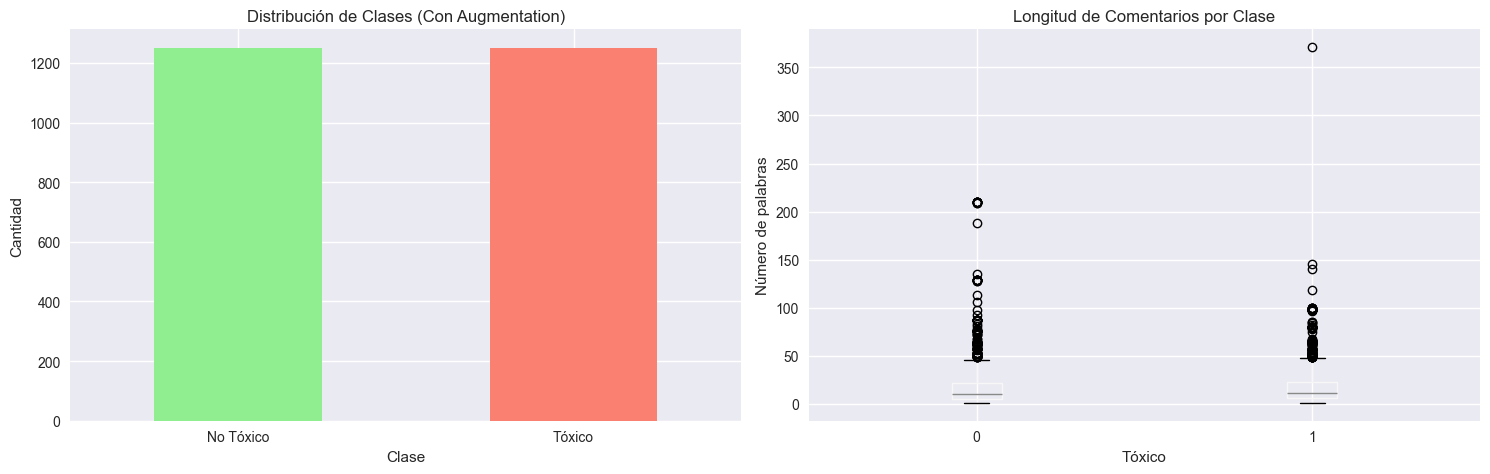

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Balance de clases
df_final['toxic_binary'].value_counts().plot(kind='bar', ax=axes[0], 
                                            color=['lightgreen', 'salmon'])
axes[0].set_title('Distribución de Clases (Con Augmentation)')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')
axes[0].set_xticklabels(['No Tóxico', 'Tóxico'], rotation=0)

# Longitud de comentarios
df_final['longitud'] = df_final['texto_procesado'].str.split().str.len()
df_final.boxplot(column='longitud', by='toxic_binary', ax=axes[1])
axes[1].set_title('Longitud de Comentarios por Clase')
axes[1].set_xlabel('Tóxico')
axes[1].set_ylabel('Número de palabras')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Wordclouds comparativos


📊 WORDCLOUDS COMPARATIVOS
   • Comentarios tóxicos para WordCloud: 1250
   • Comentarios no tóxicos para WordCloud: 1250
   • Palabras en corpus tóxico: 23543
   • Palabras en corpus no tóxico: 23950


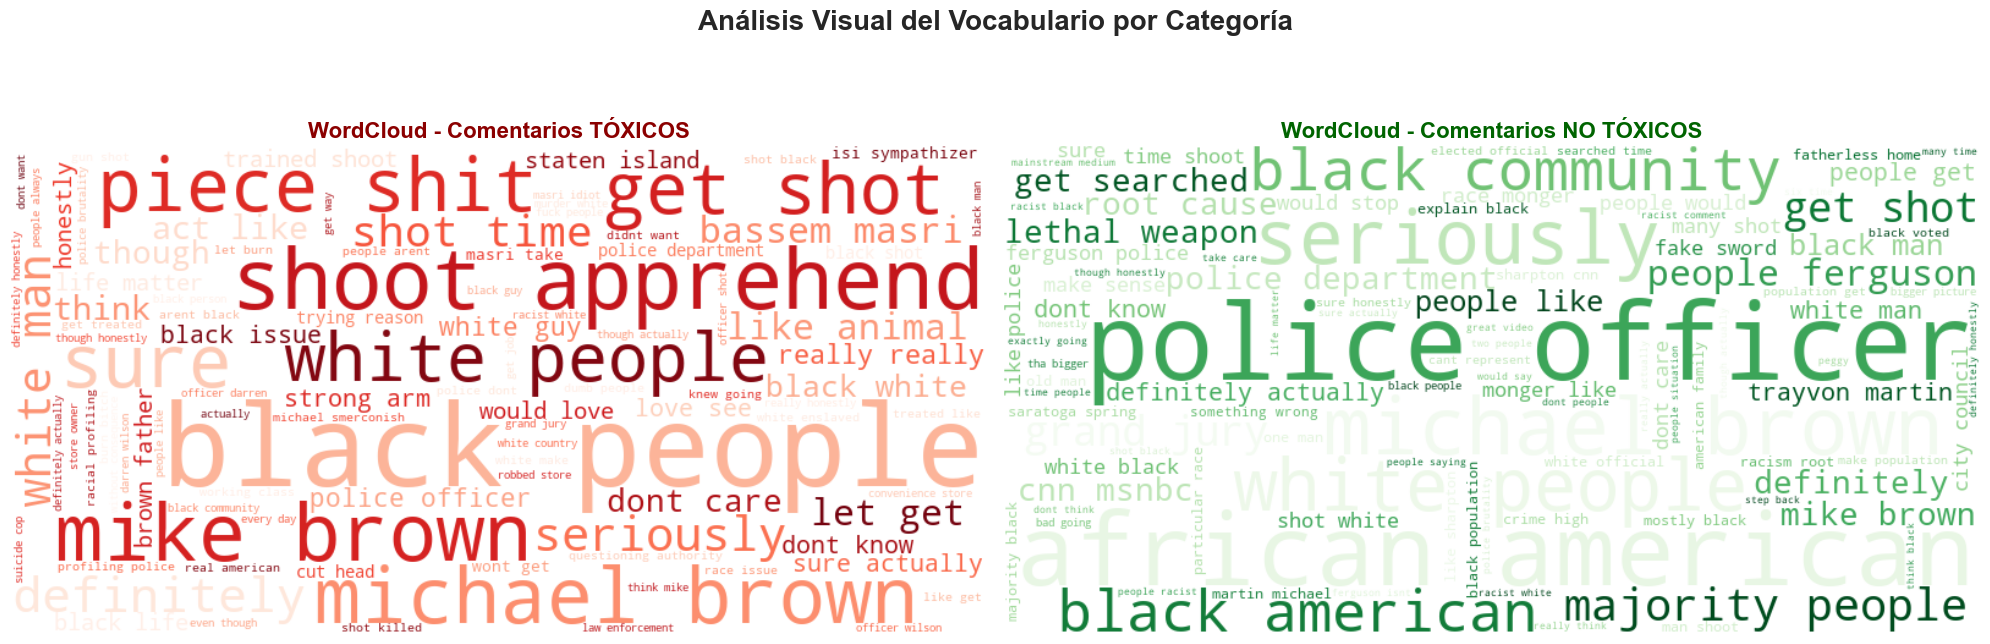

In [8]:
print("\n📊 WORDCLOUDS COMPARATIVOS")

# Separar textos por categoría usando los datos procesados
textos_toxicos = df_final[df_final['toxic_binary'] == 1]['texto_procesado']
textos_no_toxicos = df_final[df_final['toxic_binary'] == 0]['texto_procesado']

print(f"   • Comentarios tóxicos para WordCloud: {len(textos_toxicos)}")
print(f"   • Comentarios no tóxicos para WordCloud: {len(textos_no_toxicos)}")

# Combinar textos por categoría
texto_toxico_combinado = ' '.join(textos_toxicos.dropna())
texto_no_toxico_combinado = ' '.join(textos_no_toxicos.dropna())

print(f"   • Palabras en corpus tóxico: {len(texto_toxico_combinado.split())}")
print(f"   • Palabras en corpus no tóxico: {len(texto_no_toxico_combinado.split())}")

# Verificar que tenemos suficiente texto
if len(texto_toxico_combinado.split()) < 10:
    print("⚠️ Advertencia: Poco texto tóxico disponible para WordCloud")
if len(texto_no_toxico_combinado.split()) < 10:
    print("⚠️ Advertencia: Poco texto no tóxico disponible para WordCloud")

# Generar WordClouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Configuración común para ambos WordClouds
wordcloud_config = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'max_words': 100,
    'relative_scaling': 0.5,
    'stopwords': stop_words,  # Usar las mismas stopwords del preprocesamiento
    'collocation_threshold': 10
}

# WordCloud para comentarios tóxicos
if len(texto_toxico_combinado.strip()) > 0:
    wordcloud_toxico = WordCloud(
        **wordcloud_config,
        colormap='Reds'
    ).generate(texto_toxico_combinado)
    
    axes[0].imshow(wordcloud_toxico, interpolation='bilinear')
    axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16, color='darkred')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'No hay suficiente\ntexto tóxico', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=16)
    axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16, color='darkred')

# WordCloud para comentarios no tóxicos
if len(texto_no_toxico_combinado.strip()) > 0:
    wordcloud_no_toxico = WordCloud(
        **wordcloud_config,
        colormap='Greens'
    ).generate(texto_no_toxico_combinado)
    
    axes[1].imshow(wordcloud_no_toxico, interpolation='bilinear')
    axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16, color='darkgreen')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'No hay suficiente\ntexto no tóxico', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=16)
    axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16, color='darkgreen')

plt.suptitle('Análisis Visual del Vocabulario por Categoría', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# 7. Preparación para machine learning

In [9]:
print("\n🎯 Preparando datos para entrenamiento...")

# Features y target
X = df_final['texto_procesado']
y = df_final['toxic_binary']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 División de datos:")
print(f"   - Entrenamiento: {len(X_train)} ({y_train.mean()*100:.1f}% tóxicos)")
print(f"   - Prueba: {len(X_test)} ({y_test.mean()*100:.1f}% tóxicos)")


🎯 Preparando datos para entrenamiento...
📊 División de datos:
   - Entrenamiento: 2000 (50.0% tóxicos)
   - Prueba: 500 (50.0% tóxicos)


# 8. Vectorización optimizada

In [10]:
print("\n🔢 Vectorizando con TF-IDF...")

vectorizer = TfidfVectorizer(
    max_features=2000,      # Más features por más datos
    ngram_range=(1, 3),     # Incluir trigramas
    min_df=2,               # Mínima frecuencia
    max_df=0.95,            # Máxima frecuencia
    sublinear_tf=True,      # Escalado logarítmico
    use_idf=True,           # IDF para ponderar importancia
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"✅ Forma de datos vectorizados: {X_train_vec.shape}")


🔢 Vectorizando con TF-IDF...
✅ Forma de datos vectorizados: (2000, 2000)


# 9. Entrenamiento de XGBoost

In [11]:
print("\n🚀 Entrenando XGBoost optimizado...")

# Calcular peso de clases para balanceo
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Modelo XGBoost con hiperparámetros optimizados
modelo = xgb.XGBClassifier(
    # Parámetros básicos
    n_estimators=300,           # Número de árboles
    max_depth=6,                # Profundidad máxima
    learning_rate=0.1,          # Tasa de aprendizaje
    
    # Control de overfitting
    subsample=0.8,              # Submuestreo de filas
    colsample_bytree=0.8,       # Submuestreo de columnas
    reg_alpha=0.1,              # Regularización L1
    reg_lambda=1.0,             # Regularización L2
    
    # Balanceo de clases
    scale_pos_weight=scale_pos_weight,
    
    # Otros parámetros
    objective='binary:logistic',
    eval_metric=['error', 'logloss'],  # Métricas de evaluación
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    early_stopping_rounds=20    # Early stopping
)

# Entrenar con conjunto de validación
eval_set = [(X_train_vec, y_train), (X_test_vec, y_test)]
modelo.fit(
    X_train_vec, y_train,
    eval_set=eval_set,
    verbose=False
)

# Obtener información del entrenamiento
resultado_entrenamiento = modelo.evals_result()
if resultado_entrenamiento:
    # Obtener el mejor score de la validación
    val_scores = resultado_entrenamiento['validation_1']['logloss']
    mejor_iteracion = np.argmin(val_scores)
    mejor_score = val_scores[mejor_iteracion]
    print(f"✅ Mejor iteración: {mejor_iteracion + 1}")
    print(f"✅ Mejor score (logloss): {mejor_score:.4f}")

# Validación cruzada con modelo sin early stopping
print("\n📈 Realizando validación cruzada...")
modelo_cv = xgb.XGBClassifier(
    n_estimators=100,  # Menos árboles para CV rápida
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

scores_cv = cross_val_score(modelo_cv, X_train_vec, y_train, cv=5, scoring='f1')
print(f"   - F1-Scores: {[f'{s:.3f}' for s in scores_cv]}")
print(f"   - Media: {scores_cv.mean():.3f} (+/- {scores_cv.std() * 2:.3f})")


🚀 Entrenando XGBoost optimizado...


✅ Mejor iteración: 300
✅ Mejor score (logloss): 0.2254

📈 Realizando validación cruzada...
   - F1-Scores: ['0.902', '0.880', '0.856', '0.851', '0.856']
   - Media: 0.869 (+/- 0.039)


# 10. Evaluación detallada


📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:

🎯 Métricas principales:
   - Accuracy: 0.912
   - F1-Score: 0.911

📋 Reporte de clasificación:
              precision    recall  f1-score   support

   No Tóxico      0.899     0.928     0.913       250
      Tóxico      0.926     0.896     0.911       250

    accuracy                          0.912       500
   macro avg      0.912     0.912     0.912       500
weighted avg      0.912     0.912     0.912       500



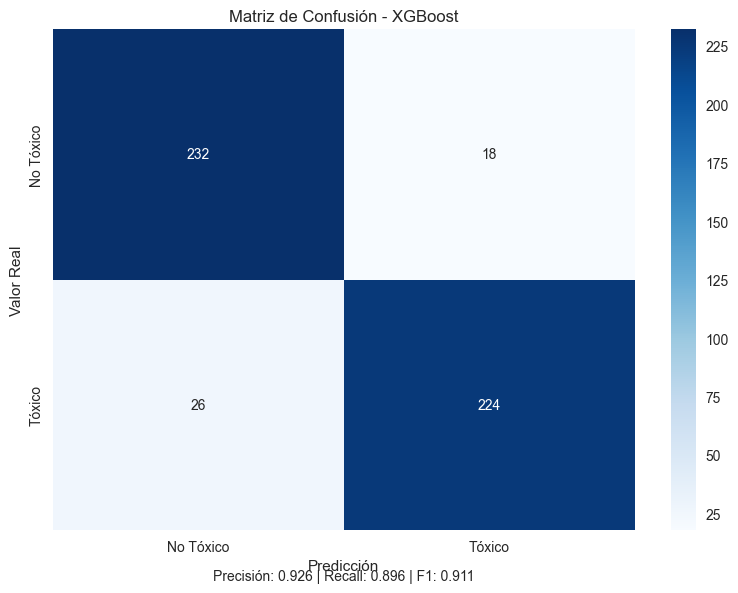

In [12]:
print("\n📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:")

# Predicciones
y_pred = modelo.predict(X_test_vec)
y_pred_proba = modelo.predict_proba(X_test_vec)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n🎯 Métricas principales:")
print(f"   - Accuracy: {accuracy:.3f}")
print(f"   - F1-Score: {f1:.3f}")

# Reporte completo
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Tóxico', 'Tóxico'],
                          digits=3))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tóxico', 'Tóxico'],
            yticklabels=['No Tóxico', 'Tóxico'])
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')

# Agregar métricas en el título
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
plt.text(0.5, -0.1, f'Precisión: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}', 
         ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 11. Análisis de importancia de features


🔤 ANÁLISIS DE IMPORTANCIA DE FEATURES:

🏆 Top 20 features más importantes:
   'black people': 0.0218
   'majority': 0.0198
   'thug': 0.0142
   'fuck': 0.0139
   'killed': 0.0133
   'idiot': 0.0128
   'shoot apprehend': 0.0124
   'shit': 0.0118
   'six': 0.0117
   'full': 0.0115
   'bitch': 0.0113
   'way': 0.0110
   'ferguson': 0.0108
   'never': 0.0108
   'started': 0.0101
   'african american': 0.0095
   'absolutely': 0.0094
   'terrorist': 0.0089
   'isi': 0.0087
   'cnn': 0.0084


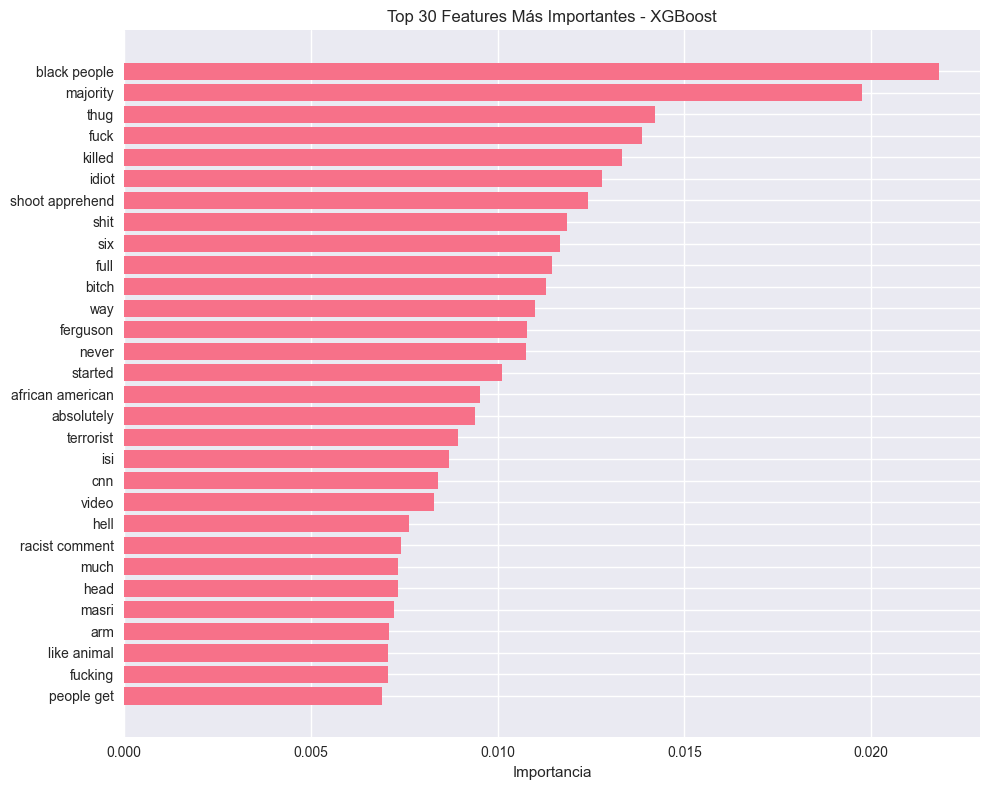


📊 Análisis detallado de importancia:

WEIGHT:
   'people': 74.0000
   'cnn': 50.0000
   'shot': 44.0000
   'cop': 43.0000
   'black': 41.0000
   'like': 41.0000
   'one': 41.0000
   'white': 37.0000
   'guy': 36.0000
   'know': 35.0000

GAIN:
   'black people': 21.0926
   'majority': 19.1038
   'thug': 13.7514
   'fuck': 13.3913
   'killed': 12.8869
   'idiot': 12.3685
   'shoot apprehend': 12.0162
   'shit': 11.4501
   'six': 11.2860
   'full': 11.0799

COVER:
   'majority': 318.9196
   'shoot apprehend': 307.9702
   'like animal': 290.9046
   'black people': 288.6966
   'started': 278.6439
   'full': 273.7532
   'way': 273.4649
   'shit': 270.9573
   'knew going': 267.7867
   'people get': 262.5221


In [13]:
print("\n🔤 ANÁLISIS DE IMPORTANCIA DE FEATURES:")

# Obtener importancia de features de XGBoost
feature_names = vectorizer.get_feature_names_out()
importancias = modelo.feature_importances_

# Crear DataFrame de importancias
df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values('importance', ascending=False)

# Top 20 features más importantes
print("\n🏆 Top 20 features más importantes:")
for idx, row in df_importancia.head(20).iterrows():
    print(f"   '{row['feature']}': {row['importance']:.4f}")

# Visualizar importancia de features
plt.figure(figsize=(10, 8))
top_features = df_importancia.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 30 Features Más Importantes - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Análisis adicional: Gain vs Cover
if hasattr(modelo, 'get_booster'):
    print("\n📊 Análisis detallado de importancia:")
    importance_types = ['weight', 'gain', 'cover']
    
    for imp_type in importance_types:
        importances_dict = modelo.get_booster().get_score(importance_type=imp_type)
        if importances_dict:
            print(f"\n{imp_type.upper()}:")
            sorted_imp = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)[:10]
            for feat, score in sorted_imp:
                if feat.startswith('f'):
                    feat_idx = int(feat[1:])
                    feat_name = feature_names[feat_idx]
                    print(f"   '{feat_name}': {score:.4f}")

# 12. Función de predicción

In [14]:
def predecir_toxicidad(texto, modelo=modelo, vectorizer=vectorizer):
    """
    Predice si un comentario es tóxico.
    
    Retorna:
    - etiqueta: 'TÓXICO' o 'NO TÓXICO'
    - confianza: probabilidad de la predicción
    """
    # Preprocesar
    texto_limpio = limpiar_texto(texto)
    texto_procesado = procesar_texto(texto_limpio)
    
    # Vectorizar
    texto_vec = vectorizer.transform([texto_procesado])
    
    # Predecir
    prediccion = modelo.predict(texto_vec)[0]
    probabilidad = modelo.predict_proba(texto_vec)[0, 1]
    
    etiqueta = "TÓXICO ⚠️" if prediccion == 1 else "NO TÓXICO ✅"
    confianza = probabilidad if prediccion == 1 else (1 - probabilidad)
    
    return etiqueta, confianza

# Probar con ejemplos
print("\n🧪 PRUEBAS CON COMENTARIOS NUEVOS:")

ejemplos = [
    "Great video, thanks for sharing!",
    "You're so stupid and ignorant",
    "I disagree with your opinion",
    "This is garbage content, delete it",
    "Interesting perspective, never thought about it that way"
]

for comentario in ejemplos:
    etiqueta, confianza = predecir_toxicidad(comentario)
    print(f"\n📝 '{comentario}'")
    print(f"   → {etiqueta} (Confianza: {confianza:.1%})")


🧪 PRUEBAS CON COMENTARIOS NUEVOS:

📝 'Great video, thanks for sharing!'
   → NO TÓXICO ✅ (Confianza: 95.3%)

📝 'You're so stupid and ignorant'
   → TÓXICO ⚠️ (Confianza: 76.5%)

📝 'I disagree with your opinion'
   → NO TÓXICO ✅ (Confianza: 71.3%)

📝 'This is garbage content, delete it'
   → NO TÓXICO ✅ (Confianza: 71.3%)

📝 'Interesting perspective, never thought about it that way'
   → NO TÓXICO ✅ (Confianza: 74.0%)


# 13. Análisis de overfitting


🔍 ANÁLISIS DE OVERFITTING

📊 COMPARACIÓN DE MÉTRICAS POR CONJUNTO:
----------------------------------------

Entrenamiento:
  ACCURACY: 0.9680
  PRECISION: 0.9916
  RECALL: 0.9440
  F1: 0.9672
  AUC: 0.9946

Prueba:
  ACCURACY: 0.9120
  PRECISION: 0.9256
  RECALL: 0.8960
  F1: 0.9106
  AUC: 0.9740

🚨 DETECCIÓN DE OVERFITTING:
------------------------------
📈 F1 Train vs Test: 0.0566
⚠️  OVERFITTING MODERADO detectado (Train >> Test)

📊 GENERANDO VISUALIZACIONES...
📈 Calculando curvas de aprendizaje...


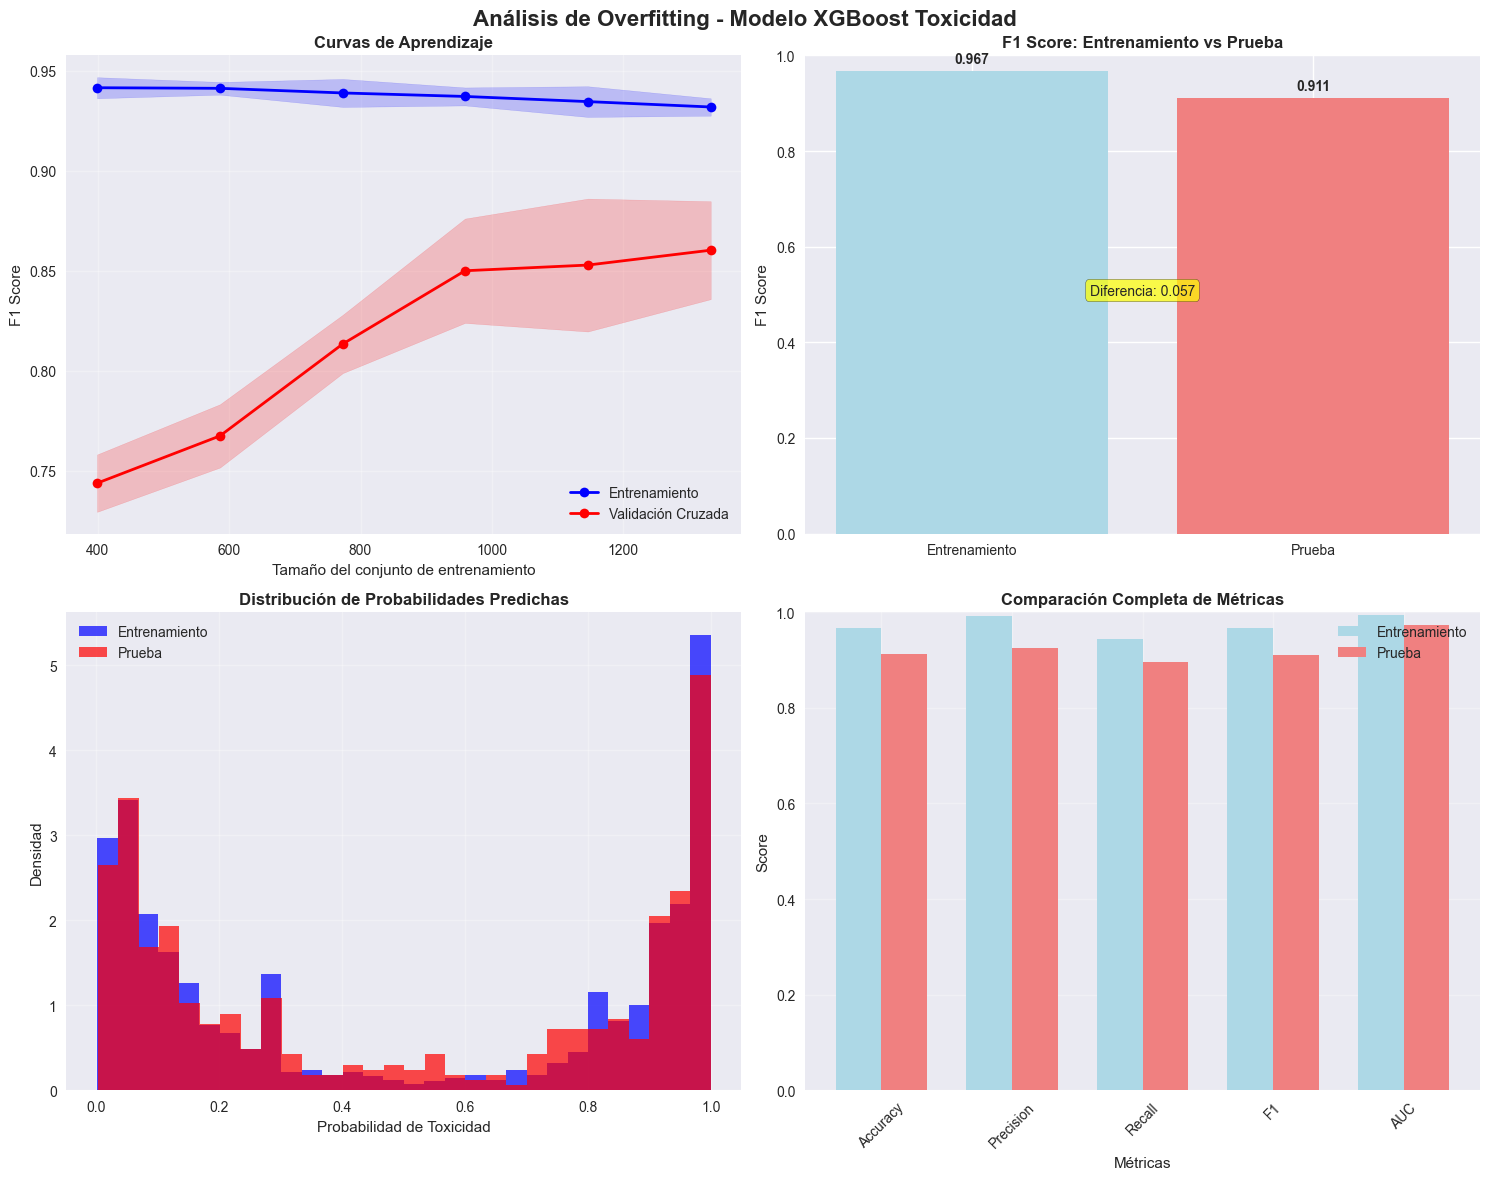


📋 REPORTE FINAL DE OVERFITTING
📊 ANÁLISIS DETALLADO:
   • F1 Entrenamiento: 0.9672
   • F1 Prueba:        0.9106

🔍 GAP DE RENDIMIENTO:
   • Train-Test gap:   0.0566

🩺 DIAGNÓSTICO:
   ⚠️  MODERADO: Overfitting detectado

💡 RECOMENDACIÓN:
   Considerar más regularización o early stopping más agresivo

🎯 CAPACIDAD DE GENERALIZACIÓN: 15.0/100 🟠
   👎 GENERALIZACIÓN BAJA - Hay overfitting, revisar modelo

🎯 ANÁLISIS ESPECÍFICO PARA TOXICIDAD:
   • Gap Precision: 0.0660
   • Gap Recall:    0.0480

✅ ANÁLISIS DE OVERFITTING COMPLETADO

📈 ANÁLISIS ADICIONAL: DISTRIBUCIÓN DE CONFIANZA
--------------------------------------------------
📊 Distribución de confianza en predicciones de prueba:
   • Alta confianza (>80% o <20%):  382 (76.4%)
   • Media confianza (60-80%, 20-40%):  90 (18.0%)
   • Baja confianza (40-60%):        28 (5.6%)

🎯 Accuracy por nivel de confianza:
   • Alta confianza: 0.976
   • Media confianza: 0.778
   • Baja confianza: 0.464

💡 Interpretación:
   ✅ Modelo hace prediccio

In [15]:
def analizar_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test):
    """
    Análisis completo de overfitting del modelo XGBoost
    Adaptado para el notebook de detección de toxicidad
    """
    
    print("🔍 ANÁLISIS DE OVERFITTING")
    print("=" * 50)
    
    # 1. MÉTRICAS COMPARATIVAS ENTRE CONJUNTOS
    print("\n📊 COMPARACIÓN DE MÉTRICAS POR CONJUNTO:")
    print("-" * 40)
    
    conjuntos_datos = {
        'Entrenamiento': (X_train_vec, y_train),
        'Prueba': (X_test_vec, y_test)
    }
    
    comparacion_metricas = {}
    
    for nombre, (X, y) in conjuntos_datos.items():
        y_pred = modelo_xgb.predict(X)
        y_proba = modelo_xgb.predict_proba(X)[:, 1]
        
        metricas = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'auc': roc_auc_score(y, y_proba)
        }
        
        comparacion_metricas[nombre] = metricas
        
        print(f"\n{nombre}:")
        for metrica, valor in metricas.items():
            print(f"  {metrica.upper()}: {valor:.4f}")
    
    # 2. DETECTAR OVERFITTING
    print(f"\n🚨 DETECCIÓN DE OVERFITTING:")
    print("-" * 30)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Diferencias
    train_test_diff = train_f1 - test_f1
    
    print(f"📈 F1 Train vs Test: {train_test_diff:.4f}")
    
    # Análisis de overfitting
    overfitting_detectado = False
    
    if train_test_diff > 0.08:  # Más de 8% de diferencia es preocupante
        print("❌ OVERFITTING SEVERO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.05:  # Más de 5% de diferencia
        print("⚠️  OVERFITTING MODERADO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.02:  # Ligero overfitting
        print("⚠️  LIGERO OVERFITTING detectado")
        overfitting_detectado = True
    
    if not overfitting_detectado:
        print("✅ NO se detecta overfitting significativo")
        print("✅ Modelo tiene buena generalización")
    
    return comparacion_metricas

def graficar_analisis_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas):
    """
    Visualizaciones para análisis de overfitting
    Adaptado para el modelo XGBoost del notebook
    """
    
    print(f"\n📊 GENERANDO VISUALIZACIONES...")
    
    # Crear subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis de Overfitting - Modelo XGBoost Toxicidad', fontsize=16, fontweight='bold')
    
    # Subplot 1: Curvas de aprendizaje
    print("📈 Calculando curvas de aprendizaje...")
    
    # Crear un modelo XGBoost sin early stopping para las curvas de aprendizaje
    modelo_sin_early_stopping = xgb.XGBClassifier(
        n_estimators=100,  # Menos árboles para ser más rápido
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )
    
    train_sizes, train_scores, val_scores = learning_curve(
        modelo_sin_early_stopping, X_train_vec, y_train,
        cv=3, 
        train_sizes=np.linspace(0.3, 1.0, 6),  # Empezar con más datos para evitar problemas
        scoring='f1',
        n_jobs=-1
    )
    
    # Calcular medias y desviaciones
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[0, 0].plot(train_sizes, train_mean, 'o-', color='blue', label='Entrenamiento', linewidth=2)
    axes[0, 0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    axes[0, 0].plot(train_sizes, val_mean, 'o-', color='red', label='Validación Cruzada', linewidth=2)
    axes[0, 0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    axes[0, 0].set_xlabel('Tamaño del conjunto de entrenamiento')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title('Curvas de Aprendizaje', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Comparación de métricas Train vs Test
    conjuntos = ['Entrenamiento', 'Prueba']
    f1_scores = [
        comparacion_metricas['Entrenamiento']['f1'],
        comparacion_metricas['Prueba']['f1']
    ]
    
    colores = ['lightblue', 'lightcoral']
    barras = axes[0, 1].bar(conjuntos, f1_scores, color=colores)
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score: Entrenamiento vs Prueba', fontweight='bold')
    axes[0, 1].set_ylim(0, 1)
    
    # Añadir valores en las barras
    for barra, score in zip(barras, f1_scores):
        axes[0, 1].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Línea de referencia para mostrar la diferencia
    diferencia = abs(f1_scores[0] - f1_scores[1])
    axes[0, 1].text(0.5, 0.5, f'Diferencia: {diferencia:.3f}', 
                   transform=axes[0, 1].transAxes, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Subplot 3: Distribución de probabilidades por conjunto
    y_proba_train = modelo_xgb.predict_proba(X_train_vec)[:, 1]
    y_proba_test = modelo_xgb.predict_proba(X_test_vec)[:, 1]
    
    axes[1, 0].hist(y_proba_train, bins=30, alpha=0.7, label='Entrenamiento', color='blue', density=True)
    axes[1, 0].hist(y_proba_test, bins=30, alpha=0.7, label='Prueba', color='red', density=True)
    axes[1, 0].set_xlabel('Probabilidad de Toxicidad')
    axes[1, 0].set_ylabel('Densidad')
    axes[1, 0].set_title('Distribución de Probabilidades Predichas', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Subplot 4: Todas las métricas comparadas
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    train_metricas = [comparacion_metricas['Entrenamiento'][m.lower()] for m in metricas]
    test_metricas = [comparacion_metricas['Prueba'][m.lower()] for m in metricas]
    
    x = np.arange(len(metricas))
    ancho = 0.35
    
    axes[1, 1].bar(x - ancho/2, train_metricas, ancho, label='Entrenamiento', color='lightblue')
    axes[1, 1].bar(x + ancho/2, test_metricas, ancho, label='Prueba', color='lightcoral')
    
    axes[1, 1].set_xlabel('Métricas')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Comparación Completa de Métricas', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metricas, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def generar_reporte_overfitting(comparacion_metricas):
    """
    Generar reporte final de overfitting
    """
    
    print(f"\n📋 REPORTE FINAL DE OVERFITTING")
    print("=" * 50)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Análisis detallado
    print(f"📊 ANÁLISIS DETALLADO:")
    print(f"   • F1 Entrenamiento: {train_f1:.4f}")
    print(f"   • F1 Prueba:        {test_f1:.4f}")
    
    gap_train_test = train_f1 - test_f1
    
    print(f"\n🔍 GAP DE RENDIMIENTO:")
    print(f"   • Train-Test gap:   {gap_train_test:.4f}")
    
    # Diagnóstico
    print(f"\n🩺 DIAGNÓSTICO:")
    
    if gap_train_test < 0.02:
        print("   ✅ EXCELENTE: Modelo muy bien generalizado")
        recomendacion = "El modelo está listo para producción"
        color_estado = "🟢"
        
    elif gap_train_test < 0.05:
        print("   ✅ BUENO: Ligero overfitting, pero aceptable")
        recomendacion = "Modelo aceptable para producción con monitoreo"
        color_estado = "🟡"
        
    elif gap_train_test < 0.08:
        print("   ⚠️  MODERADO: Overfitting detectado")
        recomendacion = "Considerar más regularización o early stopping más agresivo"
        color_estado = "🟠"
        
    else:
        print("   ❌ SEVERO: Overfitting significativo")
        recomendacion = "Necesario ajustar hiperparámetros o reentrenar"
        color_estado = "🔴"
    
    print(f"\n💡 RECOMENDACIÓN:")
    print(f"   {recomendacion}")
    
    # Métricas de generalización (no "confianza" para evitar confusión)
    puntaje_generalizacion = max(0, 100 - (gap_train_test * 100 * 15))
    print(f"\n🎯 CAPACIDAD DE GENERALIZACIÓN: {puntaje_generalizacion:.1f}/100 {color_estado}")
    
    if puntaje_generalizacion >= 85:
        print("   🏆 EXCELENTE generalización - Modelo muy robusto")
    elif puntaje_generalizacion >= 70:
        print("   👍 BUENA generalización - Modelo confiable")
    elif puntaje_generalizacion >= 50:
        print("   ⚠️  GENERALIZACIÓN MEDIA - Modelo aceptable con reservas")
    else:
        print("   👎 GENERALIZACIÓN BAJA - Hay overfitting, revisar modelo")
    
    # Análisis adicional específico para detección de toxicidad
    print(f"\n🎯 ANÁLISIS ESPECÍFICO PARA TOXICIDAD:")
    
    train_precision = comparacion_metricas['Entrenamiento']['precision']
    test_precision = comparacion_metricas['Prueba']['precision']
    precision_gap = train_precision - test_precision
    
    train_recall = comparacion_metricas['Entrenamiento']['recall']
    test_recall = comparacion_metricas['Prueba']['recall']
    recall_gap = train_recall - test_recall
    
    print(f"   • Gap Precision: {precision_gap:.4f}")
    print(f"   • Gap Recall:    {recall_gap:.4f}")
    
    if precision_gap > 0.1:
        print("   ⚠️  Modelo podría estar generando muchos falsos positivos en producción")
    if recall_gap > 0.1:
        print("   ⚠️  Modelo podría estar perdiendo comentarios tóxicos en producción")

# EJECUTAR ANÁLISIS COMPLETO DE OVERFITTING
# 1. Analizar overfitting con las métricas
comparacion_metricas = analizar_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test
)

# 2. Generar visualizaciones
graficar_analisis_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas
)

# 3. Generar reporte final
generar_reporte_overfitting(comparacion_metricas)

print(f"\n✅ ANÁLISIS DE OVERFITTING COMPLETADO")
print("="*70)

# ANÁLISIS ADICIONAL: PREDICCIONES POR CONFIANZA
print(f"\n📈 ANÁLISIS ADICIONAL: DISTRIBUCIÓN DE CONFIANZA")
print("-" * 50)

# Analizar las predicciones por nivel de confianza
y_proba_test = modelo.predict_proba(X_test_vec)[:, 1]

# Categorizar predicciones por confianza
alta_confianza = (y_proba_test >= 0.8) | (y_proba_test <= 0.2)
media_confianza = ((y_proba_test >= 0.6) & (y_proba_test < 0.8)) | ((y_proba_test > 0.2) & (y_proba_test <= 0.4))
baja_confianza = (y_proba_test > 0.4) & (y_proba_test < 0.6)

print(f"📊 Distribución de confianza en predicciones de prueba:")
print(f"   • Alta confianza (>80% o <20%):  {alta_confianza.sum():3d} ({alta_confianza.mean()*100:.1f}%)")
print(f"   • Media confianza (60-80%, 20-40%): {media_confianza.sum():3d} ({media_confianza.mean()*100:.1f}%)")
print(f"   • Baja confianza (40-60%):       {baja_confianza.sum():3d} ({baja_confianza.mean()*100:.1f}%)")

# Calcular accuracy por nivel de confianza
if alta_confianza.sum() > 0:
    acc_alta = accuracy_score(y_test[alta_confianza], (y_proba_test[alta_confianza] > 0.5))
    print(f"\n🎯 Accuracy por nivel de confianza:")
    print(f"   • Alta confianza: {acc_alta:.3f}")

if media_confianza.sum() > 0:
    acc_media = accuracy_score(y_test[media_confianza], (y_proba_test[media_confianza] > 0.5))
    print(f"   • Media confianza: {acc_media:.3f}")

if baja_confianza.sum() > 0:
    acc_baja = accuracy_score(y_test[baja_confianza], (y_proba_test[baja_confianza] > 0.5))
    print(f"   • Baja confianza: {acc_baja:.3f}")

print(f"\n💡 Interpretación:")
if baja_confianza.mean() < 0.15:  # Menos del 15% de predicciones inciertas
    print("   ✅ Modelo hace predicciones con alta certeza individual")
    print("   📊 La mayoría de predicciones son muy seguras (>80% o <20%)")
else:
    print("   ⚠️  Considerable número de predicciones con baja certeza")
    print("   📊 Muchas predicciones están en zona gris (40-60%)")

print(f"\n🏁 ANÁLISIS COMPLETO FINALIZADO")
print("="*70)

# 14. Optimización con Optuna

In [16]:
def objective(trial):
    """Función objetivo para optimizar hiperparámetros anti-overfitting"""
    try:
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'objective': 'binary:logistic',
            'eval_metric': ['error', 'logloss'],  
            'use_label_encoder': False,  
            'random_state': 42,
            'n_jobs': 1,  # Usar 1 core para evitar conflictos en CV
            'scale_pos_weight': scale_pos_weight,
            'verbosity': 0
        }
        
        # Modelo para validación cruzada
        modelo_cv = xgb.XGBClassifier(**params)
        
        # Validación cruzada
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  
        f1_scores = cross_val_score(
            modelo_cv, X_train_vec, y_train, 
            cv=cv, scoring='f1', error_score='raise'
        )
        
        modelo_test = xgb.XGBClassifier(**params)
        modelo_test.fit(X_train_vec, y_train)
        
        train_f1 = f1_score(y_train, modelo_test.predict(X_train_vec))
        test_f1 = f1_score(y_test, modelo_test.predict(X_test_vec))
        overfitting_gap = abs(train_f1 - test_f1)
        
        train_pred_proba = modelo_test.predict_proba(X_train_vec)[:, 1]
        test_pred_proba = modelo_test.predict_proba(X_test_vec)[:, 1]
        
        from sklearn.metrics import log_loss
        train_logloss = log_loss(y_train, train_pred_proba)
        test_logloss = log_loss(y_test, test_pred_proba)
        logloss_gap = abs(train_logloss - test_logloss)
        
        # Guardar métricas
        trial.set_user_attr('cv_f1', f1_scores.mean())
        trial.set_user_attr('cv_f1_std', f1_scores.std())
        trial.set_user_attr('train_f1', train_f1)
        trial.set_user_attr('test_f1', test_f1)
        trial.set_user_attr('overfitting_gap', overfitting_gap)
        trial.set_user_attr('train_logloss', train_logloss)
        trial.set_user_attr('test_logloss', test_logloss)
        trial.set_user_attr('logloss_gap', logloss_gap)
        
        # Optimiza F1 pero penaliza overfitting en ambas métricas
        penalty = (overfitting_gap * 1.0) + (logloss_gap * 0.5)
        return f1_scores.mean() - penalty
        
    except Exception as e:
        print(f"Error en trial: {e}")
        return -1.0  # Score muy bajo para trials fallidos

def optimizar_xgboost(X_train_vec, y_train, X_test_vec, y_test, n_trials=50):
    """Optimiza hiperparámetros usando Optuna"""
    # Hacer variables globales para objective
    globals().update({
        'X_train_vec': X_train_vec, 'y_train': y_train,
        'X_test_vec': X_test_vec, 'y_test': y_test
    })
    
    # Verificar que los datos sean válidos
    print(f"Datos de entrenamiento: {X_train_vec.shape}, {len(y_train)}")
    print(f"Datos de prueba: {X_test_vec.shape}, {len(y_test)}")
    print(f"Distribución y_train: {np.bincount(y_train)}")
    
    study = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Filtrar trials exitosos
    successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value > -0.5]
    
    if not successful_trials:
        raise ValueError("No se completaron trials exitosos. Revisa tus datos.")
    
    best_trial = max(successful_trials, key=lambda x: x.value)
    
    print(f"\nMejor score: {best_trial.value:.4f}")
    print(f"CV F1: {best_trial.user_attrs['cv_f1']:.4f} (±{best_trial.user_attrs['cv_f1_std']:.4f})")
    print(f"Train F1: {best_trial.user_attrs['train_f1']:.4f}")
    print(f"Test F1: {best_trial.user_attrs['test_f1']:.4f}")
    print(f"Gap overfitting F1: {best_trial.user_attrs['overfitting_gap']:.4f}")
    print(f"Train LogLoss: {best_trial.user_attrs['train_logloss']:.4f}")  # NUEVO
    print(f"Test LogLoss: {best_trial.user_attrs['test_logloss']:.4f}")    # NUEVO
    print(f"Gap overfitting LogLoss: {best_trial.user_attrs['logloss_gap']:.4f}")  # NUEVO
    print(f"Trials exitosos: {len(successful_trials)}/{len(study.trials)}")
    
    return best_trial.params

def entrenar_modelo_final(best_params, X_train_vec, y_train, X_test_vec, y_test):
    """Entrena modelo final con parámetros optimizados - VERSIÓN CORREGIDA"""
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    final_params = {
        **best_params,
        'objective': 'binary:logistic',
        'eval_metric': ['error', 'logloss'],  
        'use_label_encoder': False,           
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight,
        'verbosity': 0
    }
    
    modelo = xgb.XGBClassifier(**final_params)
    modelo.fit(X_train_vec, y_train)
    
    # Evaluación final
    train_pred = modelo.predict(X_train_vec)
    test_pred = modelo.predict(X_test_vec)
    
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # Añadir evaluación de logloss
    train_pred_proba = modelo.predict_proba(X_train_vec)[:, 1]
    test_pred_proba = modelo.predict_proba(X_test_vec)[:, 1]
    
    from sklearn.metrics import log_loss
    train_logloss = log_loss(y_train, train_pred_proba)
    test_logloss = log_loss(y_test, test_pred_proba)
    
    # Validación cruzada final
    cv_scores = cross_val_score(
        xgb.XGBClassifier(**final_params), 
        X_train_vec, y_train, 
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
        scoring='f1'
    )
    
    print(f"\n✅ Modelo final:")
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print(f"CV F1: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")
    print(f"Overfitting gap F1: {abs(train_f1 - test_f1):.4f}")
    print(f"Train LogLoss: {train_logloss:.4f}")     
    print(f"Test LogLoss: {test_logloss:.4f}")      
    print(f"Overfitting gap LogLoss: {abs(train_logloss - test_logloss):.4f}") 
    
    return modelo, final_params

def optimizar_y_entrenar(X_train_vec, y_train, X_test_vec, y_test, n_trials=50):
    """Proceso completo de optimización y entrenamiento"""
    print("🚀 Optimizando XGBoost con Optuna...")
    
    # Verificaciones iniciales
    if len(np.unique(y_train)) != 2:
        raise ValueError("y_train debe ser binario (0 y 1)")
    
    if X_train_vec.shape[0] != len(y_train):
        raise ValueError("X_train_vec y y_train deben tener el mismo número de filas")
    
    best_params = optimizar_xgboost(X_train_vec, y_train, X_test_vec, y_test, n_trials)
    modelo_final, final_params = entrenar_modelo_final(best_params, X_train_vec, y_train, X_test_vec, y_test)
    
    return modelo_final, final_params

def guardar_modelos(modelo, vectorizer, nombre_base="modelo_toxicidad_xgboost"):
    """Guarda el modelo y vectorizer en archivos pickle"""
    import pickle
    
    # Nombres de archivos
    nombre_modelo = f"../final_model/{nombre_base}_final.pkl"
    nombre_vectorizer = f"../final_model/vectorizer_toxicidad_final.pkl"
    
    try:
        # Guardar modelo
        with open(nombre_modelo, 'wb') as f:
            pickle.dump(modelo, f)
        
        # Guardar vectorizer
        with open(nombre_vectorizer, 'wb') as f:
            pickle.dump(vectorizer, f)
        
        print(f"✅ Archivos guardados exitosamente:")
        print(f"   - {nombre_modelo}")
        print(f"   - {nombre_vectorizer}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error al guardar archivos: {e}")
        return False

try:
    # Ejecutar optimización
    modelo_optimizado, params_optimizados = optimizar_y_entrenar(
        X_train_vec, y_train, X_test_vec, y_test, n_trials=60  
    )
    
    # Mostrar mejores parámetros
    print("\n🔧 MEJORES PARÁMETROS ENCONTRADOS:")
    for param, valor in params_optimizados.items():
        if param not in ['objective', 'eval_metric', 'use_label_encoder', 'random_state', 'n_jobs', 'scale_pos_weight', 'verbosity']:
            if isinstance(valor, float):
                print(f"   {param}: {valor:.4f}")
            else:
                print(f"   {param}: {valor}")
    
    print(f"\n🎯 Optimización completada exitosamente!")
    
    # Guardar modelos   
    if 'vectorizer' in globals():
        guardar_modelos(modelo_optimizado, vectorizer)
    else:
        print("⚠️  Advertencia: 'vectorizer' no está definido. Solo guardando el modelo.")
        import pickle
        with open('../final_model/modelo_toxicidad_xgboost_final.pkl', 'wb') as f:
            pickle.dump(modelo_optimizado, f)
        print("✅ Modelo guardado: ../final_model/modelo_toxicidad_xgboost_final.pkl")
    
except Exception as e:
    print(f"❌ Error durante la optimización: {e}")
    print("\n🔍 Verificando datos...")
    
    # Diagnóstico de datos
    print(f"Forma X_train_vec: {X_train_vec.shape if 'X_train_vec' in globals() else 'No definido'}")
    print(f"Forma y_train: {y_train.shape if 'y_train' in globals() else 'No definido'}")
    print(f"Forma X_test_vec: {X_test_vec.shape if 'X_test_vec' in globals() else 'No definido'}")
    print(f"Forma y_test: {y_test.shape if 'y_test' in globals() else 'No definido'}")
    
    if 'y_train' in globals():
        print(f"Valores únicos en y_train: {np.unique(y_train)}")
        print(f"Distribución y_train: {np.bincount(y_train)}")
    
    if 'X_train_vec' in globals():
        print(f"Tipo X_train_vec: {type(X_train_vec)}")
        print(f"¿Hay NaN en X_train_vec?: {np.isnan(X_train_vec).any() if hasattr(X_train_vec, 'shape') else 'No es array'}")

[I 2025-07-15 07:26:37,654] A new study created in memory with name: no-name-cebed12d-b77e-4da2-93c4-3ae583a8b48a


🚀 Optimizando XGBoost con Optuna...
Datos de entrenamiento: (2000, 2000), 2000
Datos de prueba: (500, 2000), 500
Distribución y_train: [1000 1000]


Best trial: 0. Best value: 0.704342:   2%|▏         | 1/60 [00:06<06:37,  6.74s/it]

[I 2025-07-15 07:26:44,397] Trial 0 finished with value: 0.7043415064944712 and parameters: {'n_estimators': 144, 'max_depth': 8, 'learning_rate': 0.22227824312530747, 'subsample': 0.8197316968394073, 'colsample_bytree': 0.7312037280884873, 'reg_alpha': 0.7884126564776512, 'reg_lambda': 0.29983722471931534, 'min_child_weight': 7}. Best is trial 0 with value: 0.7043415064944712.


Best trial: 1. Best value: 0.77694:   3%|▎         | 2/60 [00:19<09:48, 10.15s/it] 

[I 2025-07-15 07:26:56,934] Trial 1 finished with value: 0.7769403659439778 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.8939819704323989, 'colsample_bytree': 0.8664885281600844, 'reg_alpha': 1.0695721622845982, 'reg_lambda': 0.9173065863634321, 'min_child_weight': 2}. Best is trial 1 with value: 0.7769403659439778.


Best trial: 1. Best value: 0.77694:   5%|▌         | 3/60 [00:24<07:33,  7.95s/it]

[I 2025-07-15 07:27:02,269] Trial 2 finished with value: 0.7756419533223406 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.13526405540621358, 'subsample': 0.7582458280396084, 'colsample_bytree': 0.8223705789444758, 'reg_alpha': 0.7060743646536888, 'reg_lambda': 1.4678017961907386, 'min_child_weight': 3}. Best is trial 1 with value: 0.7769403659439778.


Best trial: 3. Best value: 0.784286:   7%|▋         | 4/60 [00:33<07:54,  8.47s/it]

[I 2025-07-15 07:27:11,534] Trial 3 finished with value: 0.784286338778213 and parameters: {'n_estimators': 164, 'max_depth': 7, 'learning_rate': 0.06790539682592432, 'subsample': 0.8028468876827223, 'colsample_bytree': 0.8184829137724084, 'reg_alpha': 0.24178755947278865, 'reg_lambda': 3.0416488109881774, 'min_child_weight': 2}. Best is trial 3 with value: 0.784286338778213.


Best trial: 3. Best value: 0.784286:   8%|▊         | 5/60 [00:37<06:11,  6.75s/it]

[I 2025-07-15 07:27:15,237] Trial 4 finished with value: 0.7430925956222962 and parameters: {'n_estimators': 66, 'max_depth': 8, 'learning_rate': 0.2900332895916222, 'subsample': 0.8616794696232922, 'colsample_bytree': 0.7609227538346741, 'reg_alpha': 0.49738384889185555, 'reg_lambda': 3.424322802295663, 'min_child_weight': 4}. Best is trial 3 with value: 0.784286338778213.


Best trial: 3. Best value: 0.784286:  10%|█         | 6/60 [00:40<04:55,  5.47s/it]

[I 2025-07-15 07:27:18,228] Trial 5 finished with value: 0.6534505692054215 and parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.019972671123413333, 'subsample': 0.8818640804157565, 'colsample_bytree': 0.7517559963200033, 'reg_alpha': 3.31598619892637, 'reg_lambda': 1.5654382696861608, 'min_child_weight': 4}. Best is trial 3 with value: 0.784286338778213.


Best trial: 3. Best value: 0.784286:  12%|█▏        | 7/60 [00:45<04:42,  5.33s/it]

[I 2025-07-15 07:27:23,259] Trial 6 finished with value: 0.7153829583853628 and parameters: {'n_estimators': 187, 'max_depth': 4, 'learning_rate': 0.291179542051722, 'subsample': 0.8550265646722229, 'colsample_bytree': 0.8878997883128379, 'reg_alpha': 4.475188478633967, 'reg_lambda': 2.9935208942673146, 'min_child_weight': 7}. Best is trial 3 with value: 0.784286338778213.


Best trial: 3. Best value: 0.784286:  13%|█▎        | 8/60 [00:48<03:48,  4.40s/it]

[I 2025-07-15 07:27:25,666] Trial 7 finished with value: 0.6354908725212274 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.023115913784056037, 'subsample': 0.7650660661526528, 'colsample_bytree': 0.7777354579378963, 'reg_alpha': 1.3640316685517406, 'reg_lambda': 4.145400170668127, 'min_child_weight': 3}. Best is trial 3 with value: 0.784286338778213.


Best trial: 3. Best value: 0.784286:  15%|█▌        | 9/60 [00:54<04:10,  4.90s/it]

[I 2025-07-15 07:27:31,680] Trial 8 finished with value: 0.7221327019689446 and parameters: {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.050868025242681164, 'subsample': 0.8604393961508079, 'colsample_bytree': 0.7149101287359542, 'reg_alpha': 4.934565813636581, 'reg_lambda': 3.8635013987903206, 'min_child_weight': 2}. Best is trial 3 with value: 0.784286338778213.


Best trial: 9. Best value: 0.798023:  17%|█▋        | 10/60 [00:58<03:51,  4.63s/it]

[I 2025-07-15 07:27:35,682] Trial 9 finished with value: 0.7980227887969719 and parameters: {'n_estimators': 51, 'max_depth': 7, 'learning_rate': 0.21498862971580895, 'subsample': 0.8458014336081975, 'colsample_bytree': 0.8542540693371892, 'reg_alpha': 0.3794828121531109, 'reg_lambda': 1.7987439854359204, 'min_child_weight': 1}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  18%|█▊        | 11/60 [01:05<04:35,  5.62s/it]

[I 2025-07-15 07:27:43,558] Trial 10 finished with value: 0.7807479225097349 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.19602204373030296, 'subsample': 0.7035923751229639, 'colsample_bytree': 0.8508276320352263, 'reg_alpha': 2.102197780118566, 'reg_lambda': 4.799256022267647, 'min_child_weight': 1}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  20%|██        | 12/60 [01:21<06:50,  8.55s/it]

[I 2025-07-15 07:27:58,808] Trial 11 finished with value: 0.7759010104616915 and parameters: {'n_estimators': 246, 'max_depth': 7, 'learning_rate': 0.11581912737159866, 'subsample': 0.8117049461558581, 'colsample_bytree': 0.8169390504181222, 'reg_alpha': 0.19388797232626265, 'reg_lambda': 2.3041216023881286, 'min_child_weight': 1}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  22%|██▏       | 13/60 [01:35<08:07, 10.38s/it]

[I 2025-07-15 07:28:13,391] Trial 12 finished with value: 0.7871154089488986 and parameters: {'n_estimators': 223, 'max_depth': 7, 'learning_rate': 0.08742741115415721, 'subsample': 0.7825485483358331, 'colsample_bytree': 0.8424594575768845, 'reg_alpha': 1.7350117887888512, 'reg_lambda': 2.3488390422503334, 'min_child_weight': 1}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  23%|██▎       | 14/60 [01:44<07:41, 10.04s/it]

[I 2025-07-15 07:28:22,655] Trial 13 finished with value: 0.7198726604063743 and parameters: {'n_estimators': 226, 'max_depth': 7, 'learning_rate': 0.21376245340409436, 'subsample': 0.7685598576532633, 'colsample_bytree': 0.8954198325228144, 'reg_alpha': 1.8604274810929655, 'reg_lambda': 2.1962695357807607, 'min_child_weight': 6}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  25%|██▌       | 15/60 [02:04<09:36, 12.80s/it]

[I 2025-07-15 07:28:41,853] Trial 14 finished with value: 0.7852209509998381 and parameters: {'n_estimators': 269, 'max_depth': 8, 'learning_rate': 0.10054813141741378, 'subsample': 0.8371009216257869, 'colsample_bytree': 0.8459669659063404, 'reg_alpha': 2.7917932951237105, 'reg_lambda': 1.5871649006488289, 'min_child_weight': 1}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  27%|██▋       | 16/60 [02:15<09:01, 12.30s/it]

[I 2025-07-15 07:28:52,999] Trial 15 finished with value: 0.7613104664965664 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.17205158908256118, 'subsample': 0.7331112562770756, 'colsample_bytree': 0.792178142822014, 'reg_alpha': 3.326443675363776, 'reg_lambda': 2.4202744737597413, 'min_child_weight': 3}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  28%|██▊       | 17/60 [02:21<07:35, 10.60s/it]

[I 2025-07-15 07:28:59,638] Trial 16 finished with value: 0.7203640057868093 and parameters: {'n_estimators': 216, 'max_depth': 5, 'learning_rate': 0.24701520448205433, 'subsample': 0.7830954203745101, 'colsample_bytree': 0.865286959871946, 'reg_alpha': 1.5545618609071834, 'reg_lambda': 0.033653197068915564, 'min_child_weight': 5}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  30%|███       | 18/60 [02:29<06:42,  9.59s/it]

[I 2025-07-15 07:29:06,869] Trial 17 finished with value: 0.7879127267432426 and parameters: {'n_estimators': 99, 'max_depth': 7, 'learning_rate': 0.1532283926969866, 'subsample': 0.834548060564514, 'colsample_bytree': 0.8345951523026665, 'reg_alpha': 2.5253076117819138, 'reg_lambda': 1.7983675211048042, 'min_child_weight': 1}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  32%|███▏      | 19/60 [02:32<05:20,  7.82s/it]

[I 2025-07-15 07:29:10,579] Trial 18 finished with value: 0.7908032380229206 and parameters: {'n_estimators': 51, 'max_depth': 8, 'learning_rate': 0.1627527855154995, 'subsample': 0.8371594562371247, 'colsample_bytree': 0.8756262483526079, 'reg_alpha': 2.595564053683059, 'reg_lambda': 0.5736499949514333, 'min_child_weight': 2}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  33%|███▎      | 20/60 [02:36<04:24,  6.62s/it]

[I 2025-07-15 07:29:14,374] Trial 19 finished with value: 0.7737095787558153 and parameters: {'n_estimators': 52, 'max_depth': 8, 'learning_rate': 0.24349122155064257, 'subsample': 0.8357518270879034, 'colsample_bytree': 0.8753616099458807, 'reg_alpha': 3.7332301659332767, 'reg_lambda': 0.7542786626345599, 'min_child_weight': 2}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  35%|███▌      | 21/60 [02:41<04:00,  6.17s/it]

[I 2025-07-15 07:29:19,502] Trial 20 finished with value: 0.77288194573063 and parameters: {'n_estimators': 91, 'max_depth': 8, 'learning_rate': 0.1761966229756737, 'subsample': 0.8759001591776141, 'colsample_bytree': 0.89825543922872, 'reg_alpha': 2.3065301312738447, 'reg_lambda': 0.9111317648266857, 'min_child_weight': 4}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  37%|███▋      | 22/60 [02:49<04:07,  6.51s/it]

[I 2025-07-15 07:29:26,820] Trial 21 finished with value: 0.7832533041448788 and parameters: {'n_estimators': 101, 'max_depth': 7, 'learning_rate': 0.13880060560931431, 'subsample': 0.8332786680607951, 'colsample_bytree': 0.8366792794333602, 'reg_alpha': 2.772230328308411, 'reg_lambda': 1.7846024210213431, 'min_child_weight': 1}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  38%|███▊      | 23/60 [02:52<03:24,  5.52s/it]

[I 2025-07-15 07:29:30,043] Trial 22 finished with value: 0.789917329296491 and parameters: {'n_estimators': 58, 'max_depth': 6, 'learning_rate': 0.161116991055485, 'subsample': 0.8240387401138001, 'colsample_bytree': 0.8620197149387523, 'reg_alpha': 2.866029013436849, 'reg_lambda': 1.1893163187070424, 'min_child_weight': 2}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  40%|████      | 24/60 [02:55<02:47,  4.66s/it]

[I 2025-07-15 07:29:32,692] Trial 23 finished with value: 0.79495946469869 and parameters: {'n_estimators': 52, 'max_depth': 6, 'learning_rate': 0.17856405659804886, 'subsample': 0.8522396641971963, 'colsample_bytree': 0.8724961798361142, 'reg_alpha': 3.329217866031094, 'reg_lambda': 0.5431751982336213, 'min_child_weight': 3}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  42%|████▏     | 25/60 [02:57<02:18,  3.95s/it]

[I 2025-07-15 07:29:34,966] Trial 24 finished with value: 0.7888776800891402 and parameters: {'n_estimators': 53, 'max_depth': 5, 'learning_rate': 0.20406400589289087, 'subsample': 0.8541943518715399, 'colsample_bytree': 0.8745121681445382, 'reg_alpha': 3.6414103928193415, 'reg_lambda': 0.4439376583424725, 'min_child_weight': 3}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  43%|████▎     | 26/60 [03:02<02:22,  4.19s/it]

[I 2025-07-15 07:29:39,739] Trial 25 finished with value: 0.7601572833168647 and parameters: {'n_estimators': 117, 'max_depth': 6, 'learning_rate': 0.25236849623671753, 'subsample': 0.8973732795839003, 'colsample_bytree': 0.8855183223986686, 'reg_alpha': 4.0082956546987125, 'reg_lambda': 0.535515163290079, 'min_child_weight': 5}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  45%|████▌     | 27/60 [03:06<02:24,  4.38s/it]

[I 2025-07-15 07:29:44,553] Trial 26 finished with value: 0.7739137011357022 and parameters: {'n_estimators': 81, 'max_depth': 8, 'learning_rate': 0.18632852292802354, 'subsample': 0.8497897178970256, 'colsample_bytree': 0.8023441310223315, 'reg_alpha': 3.1684179368196532, 'reg_lambda': 1.1223724195006064, 'min_child_weight': 3}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  47%|████▋     | 28/60 [03:14<02:49,  5.29s/it]

[I 2025-07-15 07:29:51,975] Trial 27 finished with value: 0.7820707356420006 and parameters: {'n_estimators': 151, 'max_depth': 6, 'learning_rate': 0.2272185358678287, 'subsample': 0.8729718674038991, 'colsample_bytree': 0.8729901372739525, 'reg_alpha': 4.028347907073485, 'reg_lambda': 0.11475415522172172, 'min_child_weight': 2}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  48%|████▊     | 29/60 [03:19<02:40,  5.19s/it]

[I 2025-07-15 07:29:56,932] Trial 28 finished with value: 0.7534269905023597 and parameters: {'n_estimators': 108, 'max_depth': 7, 'learning_rate': 0.2671151202671918, 'subsample': 0.7969637801377084, 'colsample_bytree': 0.8545417213814798, 'reg_alpha': 2.36620093559855, 'reg_lambda': 0.6413482199624658, 'min_child_weight': 4}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  50%|█████     | 30/60 [03:28<03:08,  6.27s/it]

[I 2025-07-15 07:30:05,727] Trial 29 finished with value: 0.7821465039860914 and parameters: {'n_estimators': 139, 'max_depth': 8, 'learning_rate': 0.1289707859536936, 'subsample': 0.8249800980966787, 'colsample_bytree': 0.8855614230588817, 'reg_alpha': 3.01398682698657, 'reg_lambda': 0.34777096048633777, 'min_child_weight': 2}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 9. Best value: 0.798023:  52%|█████▏    | 31/60 [03:32<02:46,  5.74s/it]

[I 2025-07-15 07:30:10,235] Trial 30 finished with value: 0.7397642614766197 and parameters: {'n_estimators': 86, 'max_depth': 8, 'learning_rate': 0.21883622353651536, 'subsample': 0.8148804755174258, 'colsample_bytree': 0.8284758573154132, 'reg_alpha': 2.0141730613544437, 'reg_lambda': 1.190514032706409, 'min_child_weight': 5}. Best is trial 9 with value: 0.7980227887969719.


Best trial: 31. Best value: 0.802819:  53%|█████▎    | 32/60 [03:35<02:21,  5.04s/it]

[I 2025-07-15 07:30:13,632] Trial 31 finished with value: 0.8028188427123084 and parameters: {'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.1586901439834671, 'subsample': 0.8465083034083839, 'colsample_bytree': 0.8597390690252957, 'reg_alpha': 2.7188197087137644, 'reg_lambda': 1.3349811242197334, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  55%|█████▌    | 33/60 [03:38<01:54,  4.23s/it]

[I 2025-07-15 07:30:15,982] Trial 32 finished with value: 0.786373413940754 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.15638393861775823, 'subsample': 0.8445681351619212, 'colsample_bytree': 0.8548029589726024, 'reg_alpha': 1.2992395641465344, 'reg_lambda': 1.9310327610072213, 'min_child_weight': 3}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  57%|█████▋    | 34/60 [03:42<01:50,  4.25s/it]

[I 2025-07-15 07:30:20,279] Trial 33 finished with value: 0.790202361302651 and parameters: {'n_estimators': 70, 'max_depth': 7, 'learning_rate': 0.1850753995798912, 'subsample': 0.8729088068409832, 'colsample_bytree': 0.8633613202960925, 'reg_alpha': 2.635152100666483, 'reg_lambda': 1.3346036970486979, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  58%|█████▊    | 35/60 [03:45<01:38,  3.94s/it]

[I 2025-07-15 07:30:23,500] Trial 34 finished with value: 0.7872584358536185 and parameters: {'n_estimators': 68, 'max_depth': 6, 'learning_rate': 0.14379789966435427, 'subsample': 0.8858262982079838, 'colsample_bytree': 0.8057550123024981, 'reg_alpha': 3.6110994799853517, 'reg_lambda': 0.7870384281856937, 'min_child_weight': 3}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  60%|██████    | 36/60 [03:53<02:01,  5.05s/it]

[I 2025-07-15 07:30:31,116] Trial 35 finished with value: 0.7868867768283918 and parameters: {'n_estimators': 133, 'max_depth': 7, 'learning_rate': 0.11967356616971384, 'subsample': 0.8660735394415112, 'colsample_bytree': 0.8790602031792454, 'reg_alpha': 2.309299706202686, 'reg_lambda': 1.0203407212761326, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  62%|██████▏   | 37/60 [03:59<01:59,  5.21s/it]

[I 2025-07-15 07:30:36,715] Trial 36 finished with value: 0.8023527923867179 and parameters: {'n_estimators': 90, 'max_depth': 6, 'learning_rate': 0.16789778571668534, 'subsample': 0.8025228420999521, 'colsample_bytree': 0.8565654589775219, 'reg_alpha': 0.7358182816243706, 'reg_lambda': 2.7540014924691825, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  63%|██████▎   | 38/60 [04:04<01:55,  5.25s/it]

[I 2025-07-15 07:30:42,059] Trial 37 finished with value: 0.7922127091690011 and parameters: {'n_estimators': 91, 'max_depth': 6, 'learning_rate': 0.227604154371093, 'subsample': 0.8008583241659503, 'colsample_bytree': 0.8183971076755878, 'reg_alpha': 0.6944594798779564, 'reg_lambda': 2.761744904398717, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  65%|██████▌   | 39/60 [04:11<02:03,  5.89s/it]

[I 2025-07-15 07:30:49,425] Trial 38 finished with value: 0.7920513685679037 and parameters: {'n_estimators': 169, 'max_depth': 5, 'learning_rate': 0.20259223774444254, 'subsample': 0.7433675862369705, 'colsample_bytree': 0.8279816581187607, 'reg_alpha': 0.023313126773633286, 'reg_lambda': 2.7925574042695014, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  67%|██████▋   | 40/60 [04:15<01:42,  5.12s/it]

[I 2025-07-15 07:30:52,768] Trial 39 finished with value: 0.7763831401328944 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.18587474477772464, 'subsample': 0.7910480133459512, 'colsample_bytree': 0.7871434579328818, 'reg_alpha': 1.1178257056016445, 'reg_lambda': 3.6290301485615006, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  68%|██████▊   | 41/60 [04:17<01:23,  4.39s/it]

[I 2025-07-15 07:30:55,449] Trial 40 finished with value: 0.797293910672393 and parameters: {'n_estimators': 64, 'max_depth': 5, 'learning_rate': 0.26613518046913404, 'subsample': 0.8871621437406223, 'colsample_bytree': 0.7344698763775872, 'reg_alpha': 0.6870285069192972, 'reg_lambda': 1.9989787414916522, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  70%|███████   | 42/60 [04:20<01:09,  3.87s/it]

[I 2025-07-15 07:30:58,098] Trial 41 finished with value: 0.7976434620028953 and parameters: {'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.26229661381473557, 'subsample': 0.8919859644954833, 'colsample_bytree': 0.7412161872313021, 'reg_alpha': 0.48147038267155173, 'reg_lambda': 1.9754682025167984, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  72%|███████▏  | 43/60 [04:23<00:59,  3.48s/it]

[I 2025-07-15 07:31:00,684] Trial 42 finished with value: 0.7924686357824123 and parameters: {'n_estimators': 66, 'max_depth': 5, 'learning_rate': 0.27610799319707663, 'subsample': 0.8979024763971853, 'colsample_bytree': 0.7449437952741965, 'reg_alpha': 0.5075995626834825, 'reg_lambda': 2.040326923405873, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  73%|███████▎  | 44/60 [04:25<00:51,  3.21s/it]

[I 2025-07-15 07:31:03,255] Trial 43 finished with value: 0.7712033975758293 and parameters: {'n_estimators': 65, 'max_depth': 4, 'learning_rate': 0.29478903662410294, 'subsample': 0.8895464308634095, 'colsample_bytree': 0.7046556987017368, 'reg_alpha': 0.8964227276945731, 'reg_lambda': 3.1895050285201094, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  75%|███████▌  | 45/60 [04:28<00:47,  3.15s/it]

[I 2025-07-15 07:31:06,265] Trial 44 finished with value: 0.7920294690770705 and parameters: {'n_estimators': 79, 'max_depth': 5, 'learning_rate': 0.27597871384259, 'subsample': 0.8856500136722992, 'colsample_bytree': 0.725151330080663, 'reg_alpha': 0.4707789909247386, 'reg_lambda': 2.6324111734089097, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  77%|███████▋  | 46/60 [04:32<00:47,  3.39s/it]

[I 2025-07-15 07:31:10,223] Trial 45 finished with value: 0.7879317794225317 and parameters: {'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.2348073240851358, 'subsample': 0.8659978895252276, 'colsample_bytree': 0.7676613192174973, 'reg_alpha': 0.2999832249882061, 'reg_lambda': 1.4938267223626396, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  78%|███████▊  | 47/60 [04:35<00:41,  3.19s/it]

[I 2025-07-15 07:31:12,947] Trial 46 finished with value: 0.7753059389139334 and parameters: {'n_estimators': 95, 'max_depth': 3, 'learning_rate': 0.2580121132714423, 'subsample': 0.8780251215628765, 'colsample_bytree': 0.7394805696991918, 'reg_alpha': 0.9368727189241632, 'reg_lambda': 2.1869331985856326, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  80%|████████  | 48/60 [04:38<00:38,  3.20s/it]

[I 2025-07-15 07:31:16,179] Trial 47 finished with value: 0.7949017578708384 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.27867917549298915, 'subsample': 0.8643519431600292, 'colsample_bytree': 0.7283651768145196, 'reg_alpha': 0.6445194752134956, 'reg_lambda': 1.74818007717504, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  82%|████████▏ | 49/60 [04:42<00:36,  3.30s/it]

[I 2025-07-15 07:31:19,707] Trial 48 finished with value: 0.795106787900047 and parameters: {'n_estimators': 61, 'max_depth': 6, 'learning_rate': 0.2619637917334386, 'subsample': 0.805962822492486, 'colsample_bytree': 0.7612677080455165, 'reg_alpha': 0.047000271114746806, 'reg_lambda': 3.008782803467849, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  83%|████████▎ | 50/60 [04:45<00:33,  3.31s/it]

[I 2025-07-15 07:31:23,055] Trial 49 finished with value: 0.7949406710880301 and parameters: {'n_estimators': 85, 'max_depth': 5, 'learning_rate': 0.2089273215018033, 'subsample': 0.8998852196981111, 'colsample_bytree': 0.7118066085208415, 'reg_alpha': 1.1513101087641227, 'reg_lambda': 2.558324572519881, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  85%|████████▌ | 51/60 [04:55<00:48,  5.38s/it]

[I 2025-07-15 07:31:33,241] Trial 50 finished with value: 0.8015690540848055 and parameters: {'n_estimators': 188, 'max_depth': 6, 'learning_rate': 0.09974635792920933, 'subsample': 0.8459080452786372, 'colsample_bytree': 0.7491134886440148, 'reg_alpha': 1.4271719035451942, 'reg_lambda': 2.0556697626038725, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  87%|████████▋ | 52/60 [05:03<00:50,  6.25s/it]

[I 2025-07-15 07:31:41,532] Trial 51 finished with value: 0.718515845734987 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.07159643528741488, 'subsample': 0.8250125910740419, 'colsample_bytree': 0.7507456171100741, 'reg_alpha': 0.3007405755264847, 'reg_lambda': 1.953264638213219, 'min_child_weight': 7}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  88%|████████▊ | 53/60 [05:14<00:51,  7.43s/it]

[I 2025-07-15 07:31:51,705] Trial 52 finished with value: 0.7977254677199906 and parameters: {'n_estimators': 191, 'max_depth': 6, 'learning_rate': 0.0996396558450516, 'subsample': 0.8455938740231806, 'colsample_bytree': 0.7374593529161941, 'reg_alpha': 1.5111378954968726, 'reg_lambda': 1.5653406923411732, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  90%|█████████ | 54/60 [05:23<00:48,  8.07s/it]

[I 2025-07-15 07:32:01,260] Trial 53 finished with value: 0.796722203957147 and parameters: {'n_estimators': 185, 'max_depth': 6, 'learning_rate': 0.10313421124921715, 'subsample': 0.8441988970199423, 'colsample_bytree': 0.7196186759869753, 'reg_alpha': 1.6451179651841692, 'reg_lambda': 1.55790282851979, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  92%|█████████▏| 55/60 [05:35<00:46,  9.37s/it]

[I 2025-07-15 07:32:13,660] Trial 54 finished with value: 0.7709632366893423 and parameters: {'n_estimators': 184, 'max_depth': 7, 'learning_rate': 0.04292214764532455, 'subsample': 0.8443397719051262, 'colsample_bytree': 0.7572373499741024, 'reg_alpha': 1.4233960861716666, 'reg_lambda': 1.3841925864623956, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  93%|█████████▎| 56/60 [05:47<00:39,  9.98s/it]

[I 2025-07-15 07:32:25,072] Trial 55 finished with value: 0.7869512486800224 and parameters: {'n_estimators': 201, 'max_depth': 6, 'learning_rate': 0.09052949491505585, 'subsample': 0.8570579302032539, 'colsample_bytree': 0.7720531202728931, 'reg_alpha': 1.8727368957560095, 'reg_lambda': 1.6984626500473092, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  95%|█████████▌| 57/60 [05:56<00:29,  9.73s/it]

[I 2025-07-15 07:32:34,238] Trial 56 finished with value: 0.7778815053755237 and parameters: {'n_estimators': 152, 'max_depth': 6, 'learning_rate': 0.07303803961721929, 'subsample': 0.814509643688974, 'colsample_bytree': 0.8438056412928214, 'reg_alpha': 0.8897241650618596, 'reg_lambda': 2.2114031325948633, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  97%|█████████▋| 58/60 [06:07<00:20, 10.03s/it]

[I 2025-07-15 07:32:44,966] Trial 57 finished with value: 0.7885590647467432 and parameters: {'n_estimators': 202, 'max_depth': 6, 'learning_rate': 0.11815796821735032, 'subsample': 0.7710037717293798, 'colsample_bytree': 0.7376595772770713, 'reg_alpha': 0.4922351135209996, 'reg_lambda': 4.940686906410774, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819:  98%|█████████▊| 59/60 [06:22<00:11, 11.57s/it]

[I 2025-07-15 07:33:00,113] Trial 58 finished with value: 0.7929761203257826 and parameters: {'n_estimators': 215, 'max_depth': 7, 'learning_rate': 0.05868044216721505, 'subsample': 0.8297070719964672, 'colsample_bytree': 0.7814404597007665, 'reg_alpha': 1.2564380608922985, 'reg_lambda': 2.36642228150545, 'min_child_weight': 1}. Best is trial 31 with value: 0.8028188427123084.


Best trial: 31. Best value: 0.802819: 100%|██████████| 60/60 [06:31<00:00,  6.53s/it]


[I 2025-07-15 07:33:09,588] Trial 59 finished with value: 0.7681027647599756 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.1484542594354481, 'subsample': 0.7464865342183092, 'colsample_bytree': 0.7007337395811232, 'reg_alpha': 1.455535075922682, 'reg_lambda': 4.419676480111682, 'min_child_weight': 2}. Best is trial 31 with value: 0.8028188427123084.

Mejor score: 0.8028
CV F1: 0.8230 (±0.0133)
Train F1: 0.8876
Test F1: 0.8779
Gap overfitting F1: 0.0096
Train LogLoss: 0.3447
Test LogLoss: 0.3658
Gap overfitting LogLoss: 0.0211
Trials exitosos: 60/60

✅ Modelo final:
Train F1: 0.9074
Test F1: 0.8846
CV F1: 0.825 (±0.017)
Overfitting gap F1: 0.0227
Train LogLoss: 0.3430
Test LogLoss: 0.3709
Overfitting gap LogLoss: 0.0279

🔧 MEJORES PARÁMETROS ENCONTRADOS:
   n_estimators: 60
   max_depth: 6
   learning_rate: 0.1587
   subsample: 0.8465
   colsample_bytree: 0.8597
   reg_alpha: 2.7188
   reg_lambda: 1.3350
   min_child_weight: 2

🎯 Optimización completada exitos